In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

from time import time

import wandb

In [3]:
# print system info 
!nvidia-smi
!python --version

# print pytorch lightning version
print(f"Pytorch Version: {torch.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

Sun May 26 16:43:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 25%   33C    P8     5W / 260W |   2913MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

In [5]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "ast_baseline"
    backbone_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
    n_classes = 397 # number of classes in the dataset
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    batch_size = 4 
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 5
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(config.random_seed)

In [34]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

Number of classes in dataset: 800
Number of samples: 11243


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,366
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,366
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,366
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,366
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,366


In [35]:
# check if all species in greater_manaus are in amazonas
greater_manaus = df_audio_meta[df_audio_meta['region'] == 'greater_manaus']
amazonas = df_audio_meta[df_audio_meta['region'] == 'amazonas']

print('Number of species in greater_manaus:', len(greater_manaus['scientific_name'].unique()))
print('Number of species in amazonas:', len(amazonas['scientific_name'].unique()))

shared_species = [x for x in greater_manaus['scientific_name'].unique().tolist() if x in amazonas['scientific_name'].unique().tolist()]

print('Number of species in both regions:', len(shared_species))

Number of species in greater_manaus: 202
Number of species in amazonas: 791
Number of species in both regions: 193


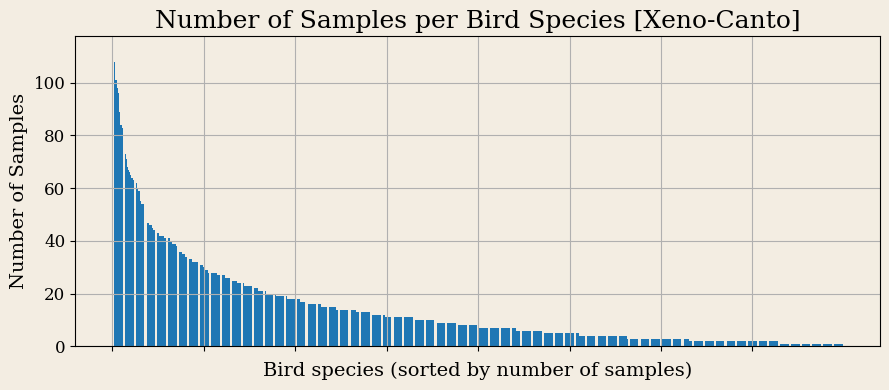

In [36]:
# calculate the number of samples per class and weights for focal loss
class_counts = df_audio_meta['species_id'].value_counts().sort_index()
class_weights = 1 / class_counts

# plot the distribution of the number of samples per class
fig, ax = plt.subplots(figsize=(9, 4))

class_counts_sorted = class_counts.sort_values(ascending=False)
ax.bar(np.arange(class_counts_sorted.shape[0]), class_counts_sorted.values)
ax.set_xticks(np.arange(0, class_counts_sorted.shape[0], 100), None) # class_counts_sorted.index[::10], rotation=90)
ax.set_xticklabels([])
# ax = plt.gca()
# ax_right = ax.twinx()
# ax_right.plot(np.arange(class_counts_sorted.shape[0]), class_weights[class_counts_sorted.index].values, color='red')

ax.tick_params(axis='y', labelcolor='black', labelsize=12, labelfontfamily='serif')
ax.set_xlabel('Bird species (sorted by number of samples)', fontsize=14, fontfamily='serif')
ax.set_ylabel('Number of Samples', fontsize=14, fontfamily='serif')
ax.set_title('Number of Samples per Bird Species [Xeno-Canto]', fontsize=18, fontfamily='serif')
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
df_audio_meta.iloc[0]

./Audio_XenoCanto/data/XC617030-guianan_trogon_0.wav


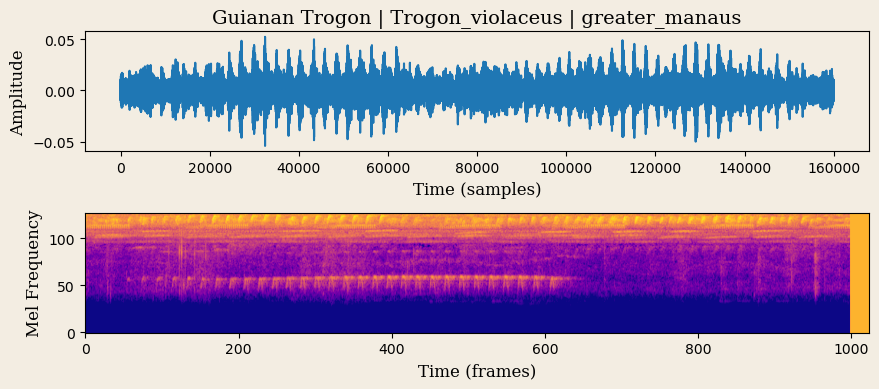

In [37]:
# visualize a sample audio file & spectrogram
sample = df_audio_meta.sample(1)

audio_file = f"{config.dataset_dir}/{sample['file_name'].values[0]}"
print(audio_file)

y, sr = librosa.load(audio_file, sr=config.audio_sr)

meta_str = f"{sample['common_name'].values[0]} | {sample['scientific_name'].values[0]} | {sample['region'].values[0]}"

fig, axes = plt.subplots(2, 1, figsize=(9, 4))

axes[0].plot(y)
axes[0].set_title(meta_str, fontsize=14, fontfamily='serif')
axes[0].set_xlabel('Time (samples)', fontsize=12, fontfamily='serif')
axes[0].set_ylabel('Amplitude', fontsize=12, fontfamily='serif')

mel_spec = ASTFeatureExtractor()(y, sampling_rate=sr, padding="max_length", return_tensors="np")["input_values"]

axes[1].imshow(mel_spec[0].T, aspect='auto', origin='lower', cmap='plasma')
axes[1].set_xlabel('Time (frames)', fontsize=12, fontfamily='serif')
axes[1].set_ylabel('Mel Frequency', fontsize=12, fontfamily='serif')

for ax in axes:
    ax.set_facecolor('#f3ede2')
    
fig.set_facecolor('#f3ede2')
fig.tight_layout()
plt.show()


In [33]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [38]:
# test the dataset and dataloader
bs_dataset = BirdSongDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

for batch in bs_dataloader:
    print(batch['input_ids'].shape)
    print(batch['labels'])
    break

torch.Size([8, 1024, 128])
tensor([201, 330, 785, 270, 496, 664, 439, 531])


In [6]:
# define loss_fn and eval_fn
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=0, alpha=None, reduction='mean', device=DEVICE):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        if isinstance(alpha, (float, int, )): 
            self.alpha = torch.Tensor([alpha, 1-alpha])
        elif isinstance(alpha, (list, np.ndarray)): 
            self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        else:
            raise TypeError('Invalid alpha type')
        
        self.ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets) # nn.CrossEntropyLoss already applies log_softmax
        pt = torch.exp(-ce_loss) # CE = -log(p_t) -> p_t = exp(-CE)
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return_method = {
            'mean': torch.mean,
            'sum': torch.sum,
            'none': lambda x: x
        }
        
        return return_method[self.reduction](focal_loss)
        
        
# eval_fn

class ROC_AUC_Score(nn.Module):
    
    def __init__(self, config, average='macro', multi_class='ovo'):
        super(ROC_AUC_Score, self).__init__()
        self.num_classes = config.n_classes
        self.average = average
        self.multi_class = multi_class  # 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
        self.label_ids = np.arange(self.num_classes)

    def forward(self, logits, targets):
        # logits: (batch_size, n_classes)
        # targets: (batch_size,) with integer labels
        
        # Apply softmax to convert logits to probabilities
        probas = torch.exp(F.log_softmax(logits, dim=1))

        # Detach and move to CPU for sklearn compatibility
        probas = probas.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        df_scores = pd.DataFrame(probas, columns=self.label_ids)
        df_scores['target'] = targets
        
        # remove samples with classes which is predeicted as 0 in all samples
        unscored_cols = df_scores.columns[df_scores.sum(axis=0) == 0]
        rows_to_remove = df_scores['target'].isin(unscored_cols)
        df_scores = df_scores[~rows_to_remove]
        
        eval_score = roc_auc_score(
            y_true=df_scores['target'].values,
            y_score=df_scores[self.label_ids].values,
            average=self.average, 
            multi_class=self.multi_class,
            labels=self.label_ids
        )
        
        return eval_score


In [ ]:
# # test loss_fn and eval_fn
# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # target_labels = torch.tensor(df_audio_meta['species_id'].sample(10).values)
# target_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print('Target Labels:', target_labels, "\n")

# Test 1: perfect prediction
# logits_perfect = F.one_hot(target_labels, num_classes=config.n_classes).float() * 100
# loss_perfect = loss_fn(logits_perfect, target_labels)

# eval_score_perfect = eval_fn(logits_perfect, target_labels)
# print(f"Perfect Prediction: Loss: {loss_perfect.item()}, Eval Score: {eval_score_perfect}")
# print(" ")

# Test 2: half correct
# half_correct = target_labels.clone()
# half_correct[:5] = (half_correct[:5] + 1) % config.n_classes  
# logits_half = F.one_hot(half_correct, num_classes=config.n_classes).float() * 100
# logits_half[:5] *= -1  
# loss_half = loss_fn(logits_half, target_labels)

# eval_score_half = eval_fn(logits_half, target_labels)
# print(f"Half Correct Prediction: Loss: {loss_half.item()}, Eval Score: {eval_score_half}")
# print(" ")

# Test 3: random prediction
# logits_random = torch.rand((10, config.n_classes))
# loss_random = loss_fn(logits_random, target_labels)

# eval_score_random = eval_fn(logits_random, target_labels)
# print(f"Random Prediction: Loss: {loss_random.item()}, Eval Score: {eval_score_random}")

In [ ]:
class BirdAST(nn.Module):
    
    def __init__(self, backbone_name, n_classes, n_mlp_layers=1, activation='silu'):
        super(BirdAST, self).__init__()
        
        # pre-trained backbone
        backbone_config = ASTConfig.from_pretrained(backbone_name)
        self.ast = ASTModel.from_pretrained(backbone_name, config=backbone_config)
        self.hidden_size = backbone_config.hidden_size
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu' or 'silu'.")
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_mels, n_frames)
        # output: (batch_size, n_classes)
        
        ast_output = self.ast(spectrogram, output_hidden_states=False)
        logits = self.mlp(ast_output.last_hidden_state[:, 0, :]) # Use the CLS token 
        
        return {'logits': logits}


In [ ]:
# # test the model / loss_fn / eval_fn using dataloader

# bs_dataset = BirdSongDataset(df_audio_meta, config)
# bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(label_ids_list, average='macro')

# bird_ast_model = BirdAST(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')

# for batch in bs_dataloader:
    
#     input_ids = batch['input_ids']
#     labels = batch['labels']
    
#     output = bird_ast_model(input_ids)
#     logits = output['logits']
    
#     loss = loss_fn(logits, labels)
#     eval_score = eval_fn(logits, labels)
    
#     print(f"Shape of input_ids: {input_ids.shape}")
#     print(f"Shape of labels: {labels.shape}")
#     print(f"Shape of logits: {logits.shape}")
#     print(f"Loss: {loss.item()}, Eval Score: {eval_score}")
    
#     break

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, logger, config, is_higher_better=True):
        '''
        model: nn.Module
        loss_fn: loss function
        evel_fn: evaluation function
        logger: logger
        config: Config
        is_higher_better: bool (default: True) whether higher evaluation score is better
        '''

        self.model = model
        self.logger = logger
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        self.is_higher_better = is_higher_better
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.weight_decay)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.epochs)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.epochs - 1)):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if self.is_higher_better:
                if valid_loss > best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
            else:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.amp)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(self.device)
            labels = data_dict['labels'].to(self.device)
            
            if is_train:
                with autocast(enabled=self.config.amp):
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.grad_accum_steps > 1:
                    train_loss = train_loss / self.config.grad_accum_steps
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                if (step + 1) % self.config.grad_accum_steps == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    valid_loss = self.loss_fn(logits, labels)

                if self.config.grad_accum_steps > 1:
                    valid_loss = valid_loss / self.config.grad_accum_steps
                    
                loss_meter.update(valid_loss.item())
                
                predicts_record.append(logits)
                labels_record.append(labels)
            
            end = time()
            
            if self.config.print_freq:
                if (step % self.config.print_freq == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {loss_meter.avg:.4f}"

                    info += f" | Elapse: {end - start:.2f}s"
                    self.logger.info(info)

        if is_train:
            wandb.log({
                "Train Loss": loss_meter.avg, 
                "Learning Rate": self.scheduler.get_last_lr()[0],
                "Gradient Norm": grad_norm,
                "Epoch": epoch_id + 1
            })
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                torch.cat(predicts_record).cpu(),
                torch.cat(labels_record).cpu()
                )
            wandb.log({
                "Valid Loss": loss_meter.avg,
                "Eval Score": eval_loss,
                "Epoch": epoch_id + 1
            })
            predicts_record = np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


In [ ]:
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [ ]:
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=False)
df_audio_meta['fold'] = 0

for fold, (train_index, valid_index) in enumerate(skf.split(df_audio_meta, df_audio_meta['species_id'])):
    df_audio_meta.loc[valid_index, 'fold'] = fold

In [ ]:
loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

oof, loss_history = pd.DataFrame(), []

logger = get_logger(log_file=f"{config.log_dir}/{config.model_name}_training.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in config.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

In [ ]:
# --------------------------------------------------------------
# Training Loop Starts Here
# --------------------------------------------------------------
    
loader_kwargs = {
    "batch_size": config.batch_size,
    "num_workers": config.num_workers,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]
    
for fold_id in range(config.n_splits):
    tik = time()
    
    wandb_init(project_name='birdsong', run_name=f"{config.model_name}|fold_{fold_id}", config=config)
    
    train_df = df_audio_meta[df_audio_meta['fold'] != fold_id].copy().reset_index(drop=True)
    valid_df = df_audio_meta[df_audio_meta['fold'] == fold_id].copy().reset_index(drop=True)
    
    train_folds = BirdSongDataset(train_df, config)
    valid_folds = BirdSongDataset(valid_df, config)
    
    train_loader = DataLoader(train_folds, **loader_kwargs)
    valid_loader = DataLoader(valid_folds, **loader_kwargs)
        
    model = BirdAST(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')
    
    trainer = Trainer(model, loss_fn, eval_fn, logger, config, is_higher_better=True)
    
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, 
        valid_loader, 
        print_epoch_freq=config.print_epoch_freq,
        from_checkpoint=None,
        use_tqdm=True
        )
    
    loss_history.append(loss_records)
    
    df_valid = pd.DataFrame({'species_id': valid_df['species_id'], 'fold': fold})
    df_valid[prediction_columns] = best_preds
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    save_model_name = f"{config.model_name}_fold_{fold_id}"
    torch.save(best_weights, f"{config.log_dir}/{save_model_name}.pth")

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    valid_loss_fold = eval_fn(
        torch.tensor(oof[prediction_columns].values),
        torch.tensor(oof['species_id'].values)
    )
    logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
        
# Summarize the final results
valid_loss = eval_fn(
    torch.tensor(oof[prediction_columns].values),
    torch.tensor(oof['species_id'].values)
)

plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(config.log_dir, f"{save_model_name}_loss.jpg"))

# Save the final oof predictions
oof.to_csv(f"{config.log_dir}/{config.model_name}_oof.csv", index=False)

In [ ]:
oof.head()

In [ ]:
# parse training log
import re 

log_file = f"{config.log_dir}/{config.model_name}_training.log"

with open(log_file, 'r') as f:
    lines = f.readlines()
    
epoch_records = []
epoch_pattern = re.compile(r"Epoch (\d+) - Train Loss: (\d+\.\d+) - Valid Loss: (\d+\.\d+) - Elapsed Time: (\d+\.\d+)s")

for line in lines:
    
    try:
        epoch, train_loss, valid_loss, elapsed = epoch_pattern.findall(line)[0]
        epoch_records.append({
            "epoch": int(epoch),
            "train_loss": float(train_loss),
            "valid_loss": float(valid_loss),
            "elapsed": float(elapsed)
        })
        
    except:
        pass
    
df_epoch_records = pd.DataFrame(epoch_records)

df_epoch_records['fold_id'] = df_epoch_records.index // 5

df_epoch_records

In [7]:
# analyze oof predictions
df_oof = pd.read_csv(f"{config.log_dir}/{config.model_name}_oof.csv")
df_oof['species_id'] = df_oof['species_id'].astype(int)

species_category = pd.cut(
    df_oof['species_id'].value_counts(), 
    bins=[0, 10, 30, 90, 120], 
    labels=['0-10', '10-30', '30-90', '90-120']
    ).to_frame()

species_category['count']

df_oof['species_category'] = df_oof['species_id'].map({i: c for i, c in enumerate(species_category['count'])})

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]

display(df_oof.head())

# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # caculate the overall evaluation loss
# eval_loss = eval_fn(
#     torch.tensor(df_oof[prediction_columns].values),
#     torch.tensor(df_oof['species_id'].values)
# )

# print(f"Overall Evaluation Loss: {eval_loss:.4f}")

,species_id,fold,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_791,pred_792,pred_793,pred_794,pred_795,pred_796,pred_797,pred_798,pred_799,species_category
0,366,4,-2.198128,-0.189352,-0.615168,-0.233942,-1.361381,-2.125353,-0.931350,-1.827894,...,0.963671,-1.483394,-0.299443,-1.168509,-0.966066,-0.591069,-1.009969,-1.013660,-0.995332,0-10
1,366,4,-2.611878,-0.154899,-0.575745,-0.341043,-1.497888,-2.092875,-1.450343,-1.847600,...,1.020791,-1.509519,-0.418200,-1.566599,-1.069373,-0.757364,-0.845977,-1.177093,-1.212171,0-10
2,366,4,-2.471305,-1.112036,-0.261239,-0.056379,-1.232901,-1.950788,-1.008180,-1.230049,...,1.566970,-0.920364,0.493877,-0.474010,-0.834652,0.169278,-1.074033,-1.573028,-1.174221,0-10
3,366,4,-2.207751,-0.655867,-0.215355,-0.210332,-1.076284,-1.782121,-1.864820,-1.333995,...,1.387784,-1.793585,0.017802,-0.511752,-0.722257,-0.711419,-1.131620,-1.365072,-0.919310,0-10
4,366,4,-2.551436,-0.964988,-0.439368,-0.116906,-1.019829,-2.194844,-1.376759,-1.485710,...,1.576066,-1.368611,0.295219,-0.599488,-0.902191,-0.011235,-1.291780,-1.367511,-1.299322,0-10


In [12]:
# make cm plots
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, save_to=None):
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    
    if save_to:
        plt.savefig(save_to)
    
    plt.show()
    
# # plot confusion matrix
# y_true = oof['species_id'].values
# y_pred = oof[prediction_columns].values.argmax(axis=1)

# plot_confusion_matrix(
#     y_true, y_pred, 
#     labels=np.arange(config.n_classes), 
#     save_to=os.path.join(config.log_dir, f"{config.model_name}_cm.jpg")
#     )


In [32]:
# calc F1, Precision, Recall, mAP 
from sklearn.metrics import f1_score, precision_score, recall_score 
import warnings

warnings.filterwarnings("ignore")

print(species_category['count'].unique())

for category_id in ['0-10', '10-30', '30-90', '90-120']:
    tmp = df_oof[df_oof['species_category'] == category_id].copy().reset_index(drop=True)

    y_true = tmp['species_id'].values
    y_pred = tmp[prediction_columns].values.argmax(axis=1)

    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"Category: {category_id} | N_samples: {len(tmp)} | N_classes: {tmp['species_id'].nunique()} | F1: {f1} | Precision: {precision} | Recall: {recall:.4f}")

    # labels = tmp['species_id'].unique()
    # cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')
    
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.title("Normalized Confusion Matrix | Category: " + category_id)
    
    # break

['90-120', '30-90', '10-30', '0-10']
Categories (4, object): ['0-10' < '10-30' < '30-90' < '90-120']
Category: 0-10 | N_samples: 6935 | N_classes: 471 | F1: 0.0036469876540175306 | Precision: 0.005893574375855413 | Recall: 0.0046
Category: 10-30 | N_samples: 3008 | N_classes: 229 | F1: 0.027642335964063427 | Precision: 0.040413137069502454 | Recall: 0.0454
Category: 30-90 | N_samples: 1210 | N_classes: 92 | F1: 0.02183171640894619 | Precision: 0.039095738697085256 | Recall: 0.0305
Category: 90-120 | N_samples: 90 | N_classes: 8 | F1: 0.018518518518518517 | Precision: 0.027777777777777776 | Recall: 0.0139


In [ ]:
# plot training progress
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax_right = ax.twinx()

for fold_id in range(config.n_splits):
    df_fold = df_epoch_records[df_epoch_records['fold_id'] == fold_id]
    ax.plot(df_fold['epoch'], df_fold['train_loss'], marker='o', label=f"Train_Fold_{fold_id}")
    ax_right.plot(df_fold['epoch'], df_fold['valid_loss'], linestyle="--", marker='*', label=f"Valid_Fold_{fold_id}")

ax.set_xticks(np.arange(0, config.epochs, 1)+1)
ax.set_xlabel("Epoch", fontsize=14, fontfamily='serif')
ax.set_ylabel("Training Loss (Focal Loss)", fontsize=14, fontfamily='serif')
ax.set_title(f"Training Progress | Overall ROCAUC: {eval_loss:.3f}", fontsize=18, fontfamily='serif')
ax.legend(loc='upper left')

ax_right.set_ylabel("Validation Loss (ROCAUC)", fontsize=14, fontfamily='serif')
ax_right.legend(loc='lower left')

ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')

fig.tight_layout()
plt.show()